In [1]:
import os
project_dir = "c:/Users/sqin34/OneDrive - UW-Madison/Research/solvgnn/"
os.chdir(project_dir)

In [2]:
import pickle
import torch
from solvgnn.model.model_GNN import solvgnn_binary, get_n_params
from solvgnn.util.generate_dataset import solvent_dataset_binary
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

Using backend: pytorch


In [3]:
saved_model_dir = project_dir + "results/job_220811_solvgnn_binary_catx/"

Summary statistics

In [4]:
valid_ind_list = np.load(saved_model_dir + 'saved_model/valid_ind_list.npy')
valid_loss_list = []
for cv_id in range(5):
    valid_loss_list.append(np.load(saved_model_dir + 'saved_model/val_loss_cv{}.npy'.format(cv_id))[-1])
print("mean CV MSE loss {:.4f}, std CV MSE loss {:.4f}".format(np.mean(valid_loss_list), np.std(valid_loss_list)))
best_cv_id = np.argmin(valid_loss_list)
print("best CV fold: {}".format(best_cv_id))

mean CV MSE loss 0.0059, std CV MSE loss 0.0020
best CV fold: 0


Load data class

In [5]:
dataset_path = project_dir + "solvgnn/data/output_binary_all.csv"
solvent_list_path = project_dir + 'solvgnn/data/solvent_list.csv'
dataset = solvent_dataset_binary(
    input_file_path=dataset_path,
    solvent_list_path = solvent_list_path,
    generate_all=True)

Check for permutation invariance

In [6]:
cv_id = 0
valid_ind = valid_ind_list[cv_id]
empty_solvsys = dataset.generate_solvsys(batch_size=1)
model = solvgnn_binary(in_dim=74, hidden_dim=256, n_classes=1).cuda()
checkpoint = torch.load(saved_model_dir + 'saved_model/final_model_cv{}.pth'.format(cv_id))
print("# model params: {}".format(get_n_params(model)))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# model params: 2840641


solvgnn_binary(
  (conv1): GraphConv(in=74, out=256, normalization=both, activation=None)
  (conv2): GraphConv(in=256, out=256, normalization=both, activation=None)
  (global_conv1): MPNNconv(
    (project_node_feats): Sequential(
      (0): Linear(in_features=257, out_features=256, bias=True)
      (1): ReLU()
    )
    (gnn_layer): NNConv(
      (edge_nn): Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=65536, bias=True)
      )
    )
    (gru): GRU(256, 256)
  )
  (classify1): Linear(in_features=256, out_features=256, bias=True)
  (classify2): Linear(in_features=256, out_features=256, bias=True)
  (classify3): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
chemical_list = ["alcohol", "water"]
smiles_list = ["CCCO", "O"]
solv1_x = 0.9
pred = dataset.predict_new(model,chemical_list,smiles_list,solv1_x,gamma_list=None)
print(pred)

[0.00479102 0.638294  ]


In [8]:
chemical_list = ["water", "alcohol"]
smiles_list = ["O", "CCCO"]
solv1_x = 0.1
pred = dataset.predict_new(model,chemical_list,smiles_list,solv1_x,gamma_list=None)
print(pred)

[0.6382939  0.00479103]


Inference individual CV samples and save for further analysis

In [60]:
idx_all = []
true_gam1_all, true_gam2_all = [], []
pred_gam1_all, pred_gam2_all = [], []
intra_hb1_all, intra_hb2_all = [], []
inter_hb_all = []
solv1_x_all = []

In [8]:
for cv_id in range(5):
    print('Analayzing CV {}'.format(cv_id+1))
    valid_ind = valid_ind_list[cv_id]
    empty_solvsys = dataset.generate_solvsys(batch_size=1)
    model = solvgnn_binary(in_dim=74, hidden_dim=256, n_classes=1).cuda()
    checkpoint = torch.load(saved_model_dir + 'saved_model/final_model_cv{}.pth'.format(cv_id))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    for count,idx in enumerate(valid_ind):
        idx_all.append(idx)
        solv1_x_all.append(dataset[idx]['solv1_x'])
        intra_hb1_all.append(dataset[idx]['intra_hb1'])
        intra_hb2_all.append(dataset[idx]['intra_hb2'])
        inter_hb_all.append(dataset[idx]['inter_hb'])
        true,pred = dataset.predict(idx,model,empty_solvsys)
        pred_gam1_all.append(pred[0])
        pred_gam2_all.append(pred[1])
        true_gam1_all.append(true[0])
        true_gam2_all.append(true[1])
        if (count+1) % 500 == 0:
            print('{} out of {} done!'.format(count+1,len(valid_ind)))

Analayzing CV 1
500 out of 40000 done!
1000 out of 40000 done!
1500 out of 40000 done!
2000 out of 40000 done!
2500 out of 40000 done!
3000 out of 40000 done!
3500 out of 40000 done!
4000 out of 40000 done!
4500 out of 40000 done!
5000 out of 40000 done!
5500 out of 40000 done!
6000 out of 40000 done!
6500 out of 40000 done!
7000 out of 40000 done!
7500 out of 40000 done!
8000 out of 40000 done!
8500 out of 40000 done!
9000 out of 40000 done!
9500 out of 40000 done!
10000 out of 40000 done!
10500 out of 40000 done!
11000 out of 40000 done!
11500 out of 40000 done!
12000 out of 40000 done!
12500 out of 40000 done!
13000 out of 40000 done!
13500 out of 40000 done!
14000 out of 40000 done!
14500 out of 40000 done!
15000 out of 40000 done!
15500 out of 40000 done!
16000 out of 40000 done!
16500 out of 40000 done!
17000 out of 40000 done!
17500 out of 40000 done!
18000 out of 40000 done!
18500 out of 40000 done!
19000 out of 40000 done!
19500 out of 40000 done!
20000 out of 40000 done!
2050

In [12]:
output_cv = pd.DataFrame({'idx':np.array(idx_all),
                          'true_gam1':np.array(true_gam1_all),
                          'pred_gam1':np.array(pred_gam1_all),
                          'true_gam2':np.array(true_gam2_all),
                          'pred_gam2':np.array(pred_gam2_all),
                          'solv1_x':np.array(solv1_x_all),
                          'intra_hb1':np.array(intra_hb1_all),
                          'intra_hb2':np.array(intra_hb2_all),
                          'inter_hb':np.array(inter_hb_all)                 
                          })

In [45]:
output_cv = output_cv.sort_values(by="idx").reset_index(drop=True)
raw_data = pd.read_csv(dataset_path)
raw_data = raw_data.rename(columns={"solv1_x": "solv1_x_input"})
output_cv = pd.concat([raw_data, output_cv], axis=1)
output_cv.to_csv(saved_model_dir + 'analysis/output_cv.csv',index=False)

In [11]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams.update({
    'text.usetex': True,
    'font.family':'serif',
    'font.serif':['Computer Modern'],
    'axes.labelsize':10,
    'xtick.labelsize':9,
    'ytick.labelsize':9})

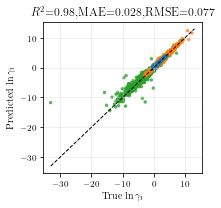

In [18]:
xmin = -33
xmax = 13
color_list = matplotlib.cm.get_cmap('tab10')
labels = ["nonpolar-nonpolar","polar-nonpolar","polar-polar"]
output_cv = pd.read_csv(saved_model_dir + 'analysis/output_cv.csv')
output_cv = pd.concat(
    (
        output_cv[["true_gam1", "pred_gam1", "tpsa_binary_avg"]]
        .rename(columns={
            "true_gam1": "true_gam",
            "pred_gam1": "pred_gam"}),
        output_cv[["true_gam2", "pred_gam2", "tpsa_binary_avg"]]
        .rename(columns={
            "true_gam2": "true_gam",
            "pred_gam2": "pred_gam"})
    ))
output_cv = output_cv.sort_values(by="tpsa_binary_avg",ascending=False)
fig,ax = plt.subplots(figsize=(3,3))
ax.grid(color='lightgray',linewidth=0.75,alpha=0.5)
ax.plot([xmin, xmax], 
           [xmin, xmax], color='black',linestyle='--', lw=1)
ax.scatter(output_cv['true_gam'],output_cv['pred_gam'],c=color_list(output_cv['tpsa_binary_avg']),s=6,alpha=0.7)
ax.set_xticks(np.arange(-30, 20, 10))
ax.set_xlabel('True $\ln\gamma_i$')
ax.set_ylabel('Predicted $\ln\gamma_i$')
ax.set_title('$R^2$={:.2f},MAE={:.3f},RMSE={:.3f}'.format(r2_score(output_cv['true_gam'],output_cv['pred_gam']),
                                                  mean_absolute_error(output_cv['true_gam'],output_cv['pred_gam']),
                                                  np.sqrt(mean_squared_error(output_cv['true_gam'],output_cv['pred_gam']))))

# ax[1].grid(color='lightgray',linewidth=0.75,alpha=0.5)
# ax[1].plot([xmin, xmax], 
#            [xmin, xmax], color='black',linestyle='--', lw=1)
# ax[1].scatter(output_cv['true_gam2'],output_cv['pred_gam2'],c=color_list(output_cv['tpsa_binary_avg']),s=6,alpha=0.7)
# ax[1].set_xlabel('True $\ln\gamma_2$')
# ax[1].set_ylabel('Predicted $\ln\gamma_2$')

# ax[1].set_title('$R^2$={:.2f},MAE={:.3f},RMSE={:.3f}'.format(r2_score(output_cv['true_gam2'],output_cv['pred_gam2']),
#                                                   mean_absolute_error(output_cv['true_gam2'],output_cv['pred_gam2']),
#                                                   np.sqrt(mean_squared_error(output_cv['true_gam2'],output_cv['pred_gam2']))))
plt.tight_layout()
plt.savefig(saved_model_dir + 'analysis/cv_parity.png',pad_inches=0,dpi=400,transparent=True)   

In [28]:
output_cv = pd.read_csv(saved_model_dir + 'analysis/output_cv.csv')
outlier1 = output_cv[output_cv.solv1_gamma < -30]
outlier2 = output_cv[output_cv.solv2_gamma < -15]

In [33]:
output_cv.columns

Index(['job_id', 'solv1', 'solv2', 'solv1_x_input', 'solv2_x', 'solv1_gamma',
       'solv2_gamma', 'warnings', 'solv1_smiles', 'solv2_smiles', 'solv1_name',
       'solv2_name', 'tpsa_binary_avg', 'idx', 'true_gam1', 'pred_gam1',
       'true_gam2', 'pred_gam2', 'solv1_x', 'intra_hb1', 'intra_hb2',
       'inter_hb'],
      dtype='object')

In [29]:
outlier1.values

array([[11907, 'solvent_394', 'solvent_540', 0.1, 0.9, -33.0367282,
        -0.1762468, nan, 'NCCNCCN', 'C#N', 'DIETHYLENETRIAMINE',
        'HYDROGEN CYANIDE', 2, 11907, -33.0367282, -11.729137,
        -0.1762468, -6.875627, 0.1, 3, 0, 1]], dtype=object)

In [32]:
outlier2.values

array([[15888, 'solvent_533', 'solvent_794', 0.9, 0.1, -0.30863494,
        -15.79282267, nan, 'CCCC(F)(F)C(F)(F)C(O)(F)F', 'OCCN(CCO)CCO',
        'HEXAFLUOROHEXANOL', 'TRIETHANOLAMINE', 2, 175888, -0.30863494,
        -0.36602384, -15.79282267, -8.344123, 0.9, 1, 3, 2]], dtype=object)